In [1]:
# detectron2 logger 설정
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# 자주 사용하는 라이브러리 임폴트
import numpy as np
import cv2
import random

# 자주 사용하는 detectron2 유틸 임폴트 
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

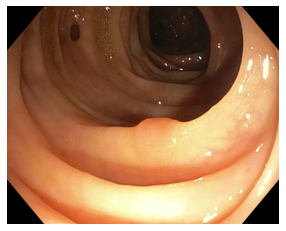

In [2]:
import matplotlib.pyplot as plt
im = cv2.imread("./trainData_EndoCV2021_5_Feb2021/data_C1/images_C1/100H0050.jpg")
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

plt.imshow(im)
plt.axis('off')
plt.show()

In [3]:
cfg = get_cfg()
# 각 테스크에 맞는 적절한 config을 추가해줍니다. 
cfg.merge_from_file("./detectron2_repo/configs/COCO-Detection/retinanet_R_50_FPN_3x.yaml")
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# detectron2 model zoo에서 다양한 모델을 사용할 수 있습니다.
cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/retinanet_R_50_FPN_3x/137849486/model_final_4cafe0.pkl"
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

Loading config ./detectron2_repo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [4]:
outputs["instances"].pred_classes
outputs["instances"].pred_boxes

Boxes(tensor([], device='cuda:0', size=(0, 4)))

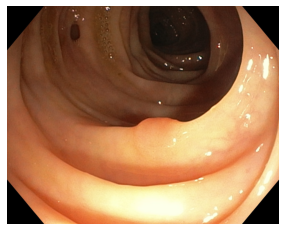

In [5]:
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

v_result = v.get_image()[:, :, ::-1]
# v_result = cv2.cvtColor(v_result, cv2.COLOR_BGR2RGB)

plt.imshow(v_result)
plt.axis('off')
plt.show()


In [6]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
import itertools
from pycocotools import mask


def get_polyp_dicts(data_dirs):
    '''
        Dataset 만드는 부분
        input:
            data_dirs: List
        return: 
            dataset_dicts: Dictionary
    '''
    base_dir = './trainData_EndoCV2021_5_Feb2021/'
    dataset_dicts = []

    cnt = 0
    for data_dir in data_dirs:
        print("LOAD " + data_dir + " STARTED.........")

        data_dir_full_path = os.path.join(base_dir, data_dir)
        dir_names = sorted(os.listdir(data_dir_full_path))

        bbox_dir = os.path.join(data_dir_full_path, dir_names[0])
        bbox_img_dir = os.path.join(data_dir_full_path, dir_names[1])
        image_dir = os.path.join(data_dir_full_path, dir_names[2])
        mask_dir = os.path.join(data_dir_full_path, dir_names[3])


        image_filenames = sorted(os.listdir(image_dir))

        for image_filename in image_filenames:
            record = {}

            image_filename_full_path = os.path.join(image_dir, image_filename)
            height, width = cv2.imread(image_filename_full_path).shape[:2]

            record["file_name"] = image_filename_full_path
            record["height"] = height
            record["width"] = width
            record["image_id"] = cnt

            cnt += 1

            fn = os.path.splitext(image_filename)[0]
            bbox_filename_full_path = os.path.join(bbox_dir, fn + "_mask.txt")
            mask_filename_full_path = os.path.join(mask_dir, fn + "_mask.jpg")
      
            objs = []

            _mask = cv2.imread(mask_filename_full_path)        
            _mask = cv2.cvtColor(_mask, cv2.COLOR_BGR2GRAY)

            # _mask를 출력해보면 binary가 아님. 
            # 0, 1, 2, ... , 8 그리고 247, 248, ... , 255 값이 들어있는 것으로 확인. 
            # binarization이 필요.
            _mask[_mask < 128] = 0
            _mask[_mask > 128] = 1
            
            with open(bbox_filename_full_path) as f:
                contents = f.readlines()

                for anno in contents:
                    anno = anno.replace("\n", "")
                    strings = anno.split(' ')
                    # annotation 형태: polyp x_min y_min x_max y_max

                    if strings[0] == 'polyp':
                        # polyp이 있는 경우만 데이터셋에 추가
                        x_min = int(strings[1])
                        y_min = int(strings[2])
                        x_max = int(strings[3])
                        y_max = int(strings[4])
                        
                        # bounding box와 segmenation mask이 둘 다 1인 부분 찾기
                        # 하나의 image에 여러 polyp이 있는 경우
                        _bbox_img = np.zeros((height, width))
                        _bbox_img[y_min:y_max, x_min:x_max] = 1
                        
                        _mask_bbox = _bbox_img * _mask
                        
                        # binary segmentation mask를 detectron2에서 요구하는 형식(COCO’s compressed RLE format) 으로 변환
                        _mask_bbox = _mask_bbox.astype('uint8')
                        _mask_dict = mask.encode(np.asarray(_mask_bbox, order="F"))
                        
                        obj = {
                            "bbox": [x_min, y_min, x_max, y_max],
                            "bbox_mode": BoxMode.XYXY_ABS,
                            "category_id": 0,
                            "iscrowd": 0,
                            "segmentation": _mask_dict
                        }
                        objs.append(obj)

            record["annotations"] = objs
            dataset_dicts.append(record)
    return dataset_dicts

    
    
    

In [7]:
from detectron2.data import DatasetCatalog, MetadataCatalog
train_data_dirs = ['data_C2', 'data_C3', 'data_C4', 'data_C5']
val_data_dirs = ['data_C1']

DatasetCatalog.register("polyp_train", lambda: get_polyp_dicts(train_data_dirs))
MetadataCatalog.get("polyp_train").set(thing_classes=["polyp"])

DatasetCatalog.register("polyp_val", lambda: get_polyp_dicts(val_data_dirs))
MetadataCatalog.get("polyp_val").set(thing_classes=["polyp"])

polyp_metadata = MetadataCatalog.get("polyp_train")

LOAD data_C2 STARTED.........
LOAD data_C3 STARTED.........
LOAD data_C4 STARTED.........
LOAD data_C5 STARTED.........
./trainData_EndoCV2021_5_Feb2021/data_C5/images_C5/EndoCV2021_C5_50000262.jpg


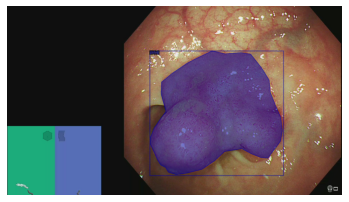

./trainData_EndoCV2021_5_Feb2021/data_C4/images_C4/18_endocv2021_positive_341.jpg


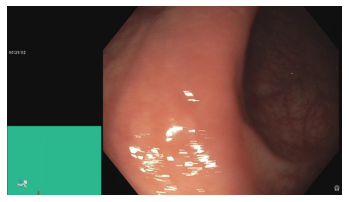

./trainData_EndoCV2021_5_Feb2021/data_C5/images_C5/EndoCV2021_C5_50000121.jpg


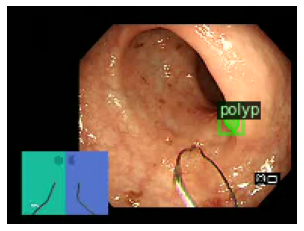

./trainData_EndoCV2021_5_Feb2021/data_C5/images_C5/EndoCV2021_C5_50000113.jpg


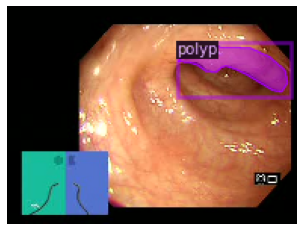

./trainData_EndoCV2021_5_Feb2021/data_C3/images_C3/C3_EndoCV2021_00364.jpg


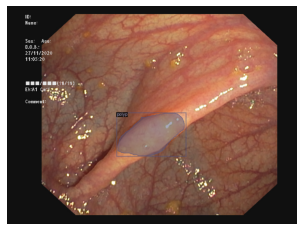

./trainData_EndoCV2021_5_Feb2021/data_C2/images_C2/EndoCV2021_001087.jpg


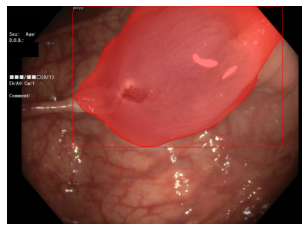

./trainData_EndoCV2021_5_Feb2021/data_C3/images_C3/C3_EndoCV2021_00155.jpg


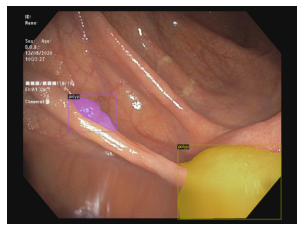

./trainData_EndoCV2021_5_Feb2021/data_C2/images_C2/EndoCV2021_001401.jpg


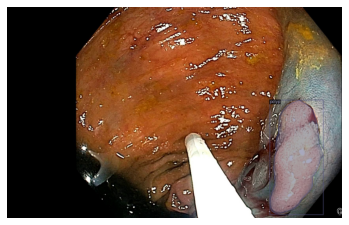

./trainData_EndoCV2021_5_Feb2021/data_C5/images_C5/EndoCV2021_C5_50000271.jpg


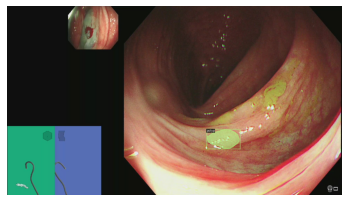

./trainData_EndoCV2021_5_Feb2021/data_C3/images_C3/C3_EndoCV2021_0012.jpg


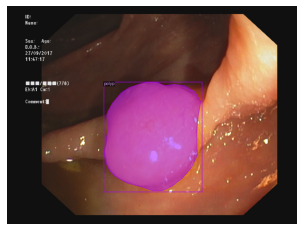

In [8]:
dataset_dicts = get_polyp_dicts(train_data_dirs)
for d in random.sample(dataset_dicts, 10):
    print(d["file_name"])
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=polyp_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    v_result = vis.get_image()[:, :, ::-1]
    v_result = cv2.cvtColor(v_result, cv2.COLOR_BGR2RGB)

    plt.imshow(v_result)
    plt.axis('off')
    plt.show()

In [9]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/myconfig/my_mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("polyp_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.INPUT.MASK_FORMAT = 'bitmask'
# cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/retinanet_R_50_FPN_3x/137849486/model_final_4cafe0.pkl"  # initialize from model zoo
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 10000    # 300 iterations 정도면 충분합니다. 더 오랜 시간도 시도해보세요.
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # 풍선 데이터셋과 같이 작은 데이터셋에서는 이정도면 적당합니다.
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # 클래스는 "풍선" 클래스 하나 뿐입니다.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[02/09 10:44:36 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[02/09 10:45:16 d2.engine.train_loop]: Starting training from iteration 0


/mnt/sda1/yeody/endocv2021/detectron2_repo/detectron2/data/detection_utils.py:415: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370141920/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  torch.stack([torch.from_numpy(np.ascontiguousarray(x)) for x in masks])
/mnt/sda1/yeody/endocv2021/detectron2_repo/detectron2/data/detection_utils.py:415: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make i

[02/09 10:45:22 d2.utils.events]:  eta: 0:42:57  iter: 19  total_loss: 1.908  loss_cls: 0.6881  loss_box_reg: 0.4964  loss_mask: 0.6967  loss_rpn_cls: 0.01902  loss_rpn_loc: 0.006908  time: 0.2592  data_time: 0.0147  lr: 4.9953e-06  max_mem: 2819M
[02/09 10:45:27 d2.utils.events]:  eta: 0:42:17  iter: 39  total_loss: 1.845  loss_cls: 0.6211  loss_box_reg: 0.4814  loss_mask: 0.687  loss_rpn_cls: 0.0184  loss_rpn_loc: 0.009346  time: 0.2513  data_time: 0.0043  lr: 9.9902e-06  max_mem: 2819M
[02/09 10:45:32 d2.utils.events]:  eta: 0:42:39  iter: 59  total_loss: 1.669  loss_cls: 0.5126  loss_box_reg: 0.4576  loss_mask: 0.6562  loss_rpn_cls: 0.01416  loss_rpn_loc: 0.003545  time: 0.2545  data_time: 0.0042  lr: 1.4985e-05  max_mem: 2850M
[02/09 10:45:38 d2.utils.events]:  eta: 0:42:46  iter: 79  total_loss: 1.516  loss_cls: 0.4033  loss_box_reg: 0.4135  loss_mask: 0.6352  loss_rpn_cls: 0.02426  loss_rpn_loc: 0.005856  time: 0.2581  data_time: 0.0044  lr: 1.998e-05  max_mem: 2850M
[02/09 10:4

In [11]:
%load_ext tensorboard
%tensorboard --logdir ./output

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [13]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("polyp_val", )
predictor = DefaultPredictor(cfg)

LOAD data_C1 STARTED.........
./trainData_EndoCV2021_5_Feb2021/data_C1/images_C1/130OLCV1_100H0002.jpg


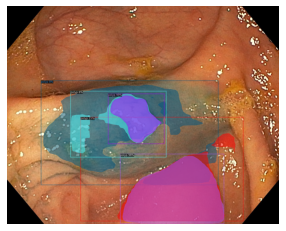

./trainData_EndoCV2021_5_Feb2021/data_C1/images_C1/278OLCV1_100H0010.jpg


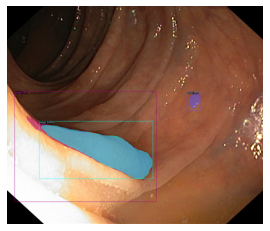

./trainData_EndoCV2021_5_Feb2021/data_C1/images_C1/314OLCV1_100H0008.jpg


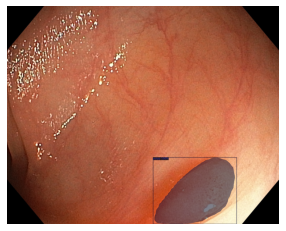

./trainData_EndoCV2021_5_Feb2021/data_C1/images_C1/459OLCV1_100H0006.jpg


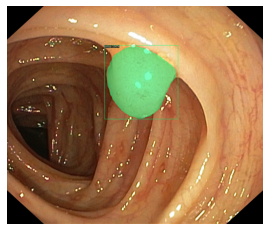

./trainData_EndoCV2021_5_Feb2021/data_C1/images_C1/419OLCV1_100H0014.jpg


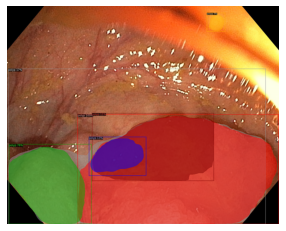

./trainData_EndoCV2021_5_Feb2021/data_C1/images_C1/493OLCV1_100H0026.jpg


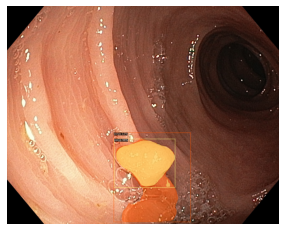

./trainData_EndoCV2021_5_Feb2021/data_C1/images_C1/195OLCV1_100H0012.jpg


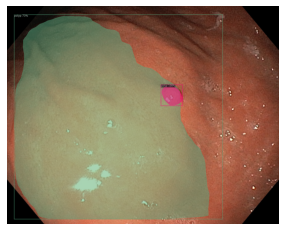

./trainData_EndoCV2021_5_Feb2021/data_C1/images_C1/434OLCV1_100S0007.jpg


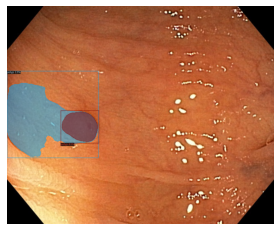

./trainData_EndoCV2021_5_Feb2021/data_C1/images_C1/177OLCV1_100H0014.jpg


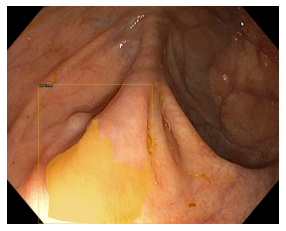

./trainData_EndoCV2021_5_Feb2021/data_C1/images_C1/204OLCV1_100H0006.jpg


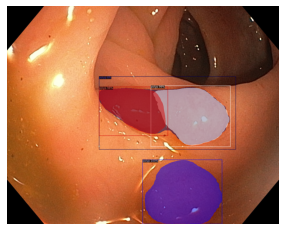

In [17]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_polyp_dicts(val_data_dirs)
for d in random.sample(dataset_dicts, 10):    
    print(d["file_name"])
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=polyp_metadata, 
                   scale=2.0
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
#         vis = visualizer.draw_dataset_dict(d)
    v_result = v.get_image()[:, :, ::-1]
    v_result = cv2.cvtColor(v_result, cv2.COLOR_BGR2RGB)

    plt.imshow(v_result)
    plt.axis('off')
    plt.show()
#     cv2_imshow(v.get_image()[:, :, ::-1])

In [18]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("polyp_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "polyp_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [02/09 13:38:08 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[02/09 13:38:08 d2.evaluation.coco_evaluation]: 'polyp_val' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[02/09 13:38:08 d2.data.datasets.coco]: Converting annotations of dataset 'polyp_val' to COCO format ...)
LOAD data_C1 STARTED.........
[02/09 13:38:18 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[02/09 13:38:18 d2.data.datasets.coco]: Conversion finished, #images: 256, #annotations: 532
[02/09 13:38:18 d2.data.datasets.coco]: Caching COCO format annotations at './output/polyp_val_coco_format.json' ...
LOAD data_C1 STARTED.........
[02/09 13:38:28 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   polyp    | 532          |
|            |              |
[02/09 13:38

OrderedDict([('bbox',
              {'AP': 31.561428139157588,
               'AP50': 45.22081714427173,
               'AP75': 34.29152202000177,
               'APs': 0.0,
               'APm': 25.841841326989844,
               'APl': 32.339291277004975}),
             ('segm',
              {'AP': 34.694085968537095,
               'AP50': 49.54406105690899,
               'AP75': 37.93279835512111,
               'APs': 0.0,
               'APm': 22.844634253341304,
               'APl': 35.76202167017769})])